<a href="https://www.kaggle.com/code/masoudmahdavii/classification-of-flags-by-transfer-learning?scriptVersionId=155291316" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0. Import libraries

In [3]:
import re
import cv2
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras.models import load_model
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Plot countries flag

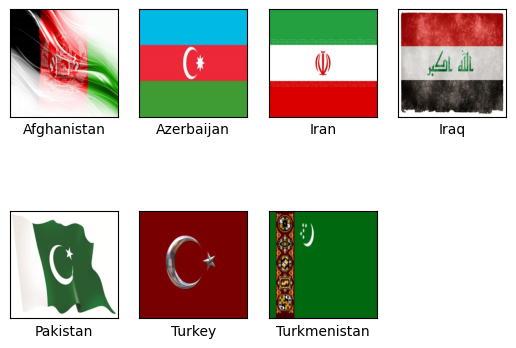

<Figure size 1600x1000 with 0 Axes>

In [4]:
train_data = "/kaggle/input/country-flags/flags/train/"
test_data = "/kaggle/input/country-flags/flags/test/"
train_data_id = "/kaggle/input/country-flags-in-the-wild/verified_flags_train/"
countries = ['Afghanistan', 'Azerbaijan','Iran', 'Iraq', 'Pakistan', 'Turkey', 'Turkmenistan']
for i, country_name in enumerate(countries):
    country_path = os.path.join(train_data,country_name)
    country_first_im = os.listdir(country_path)[0]
    image = cv2.imread(os.path.join(country_path,country_first_im))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.xlabel(country_name)
    plt.xticks([])
    plt.yticks([])
plt.figure(figsize=(16, 10))
plt.show()

# 2. Setup Paths

In [5]:
def create_paths():
    global paths
    paths = {
            'Train_path': os.path.join('Data', 'Train'),
            'Test_path': os.path.join('Data', 'Test'),
        }

    for path in paths.values():
        #Create directories (if there aren't)
        if not os.path.exists('Data'+path):
            for country in countries:
                !mkdir -p {path+'/'+country}
create_paths()

# 3. Split data into train and test sets 

In [6]:
for i, country_name in enumerate(countries):
    country_path_train = os.path.join(train_data, country_name)
    country_path_test = os.path.join(test_data, country_name)
    country_im_list_train = os.listdir(country_path_train)
    country_im_list_test = os.listdir(country_path_test)
    
    train_srcpath_list = [country_path_train+'/'+x for x in country_im_list_train]
    train_dstpath_list = [paths['Train_path']+'/'+country_name+'/'+x for x in country_im_list_train]
    
    test_srcpath_list = [country_path_test+'/'+x for x in country_im_list_test] 
    test_dstpath_list = [paths['Test_path']+'/'+country_name+'/'+x for x in country_im_list_test]
    
    train_srcpath_list.extend(test_srcpath_list)
    train_dstpath_list.extend(test_dstpath_list)

    if os.path.exists(paths['Train_path']):
        #Copy the data from the source to two directories named Train_path and Test_path.
        list(map(lambda n1, n2:shutil.copyfile(n1, n2),train_srcpath_list, train_dstpath_list))
    else:
        print("There is't train path, please run this cell again") 
        !rm -rf Data
        create_path()
        break

# 4. Create image data generators

In [7]:
# Create our image preprocessors.
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
test_datagen = ImageDataGenerator(
        rescale=1.0/255,
        validation_split=0.5,
)

In [8]:
# Define model input size and batch size.
input_size = (224, 224)
batch_size = 16

In [9]:
train_generator = train_datagen.flow_from_directory(
    paths['Train_path'],             # Path to the training data
    target_size=input_size,          # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'         # Mode for class labels (categorical for one-hot encoding)
)
val_generator = test_datagen.flow_from_directory(
    paths['Test_path'],
    target_size=input_size,
    batch_size = batch_size,
    subset="training",
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    paths['Test_path'],
    target_size=input_size,
    batch_size = batch_size,
    subset="validation",
    class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 77 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


# 4.1 Distribute Train data

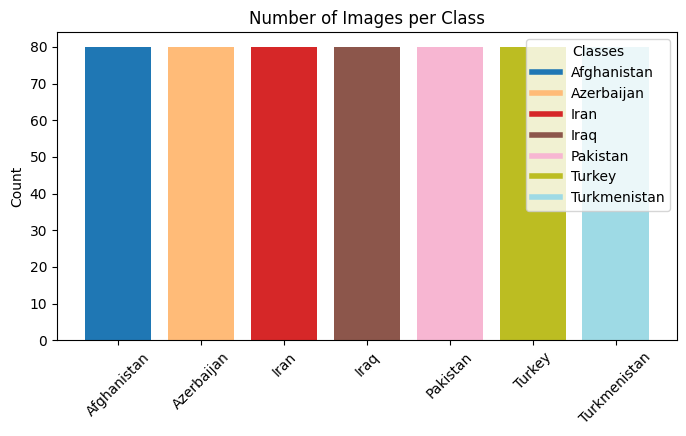

In [10]:
# Get the country labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per country
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each country
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each country
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for country colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")
plt.show()


# 4.2 Distribute Test data

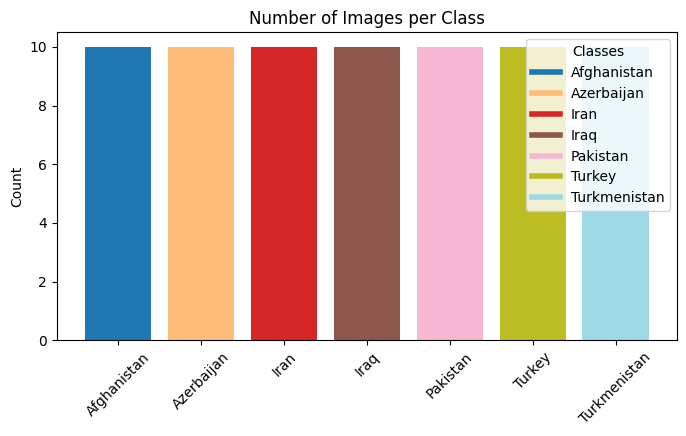

In [11]:
# Get the country labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per country
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each country
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each country
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for country colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")
plt.show()


# 5. Create classification model

Add a classification head to this pretrained model

In [12]:
def feature_extractor(inputs):
    #For feature extractor use ResNet50 model and retrain top layer from the scratch.
    weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    feature_extractor = ResNet50(input_shape=input_size + (3,),
                                               include_top=False,
                                               weights=None)       # Set the weights to None so we can load from Kaggle
    feature_extractor.trainable = True                             # Don't want to freeze feature extractor weights
    feature_extractor.load_weights(weights,by_name=True) 
    return feature_extractor(inputs)

def classifier(inputs):
    #Defines final dense layers and subsequent softmax layer for classification.
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(len(countries), activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    #resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)    # Define resize if you want to resize input images
    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def define_compile_model():
    #Let's define Opitmizer and Loss function
    inputs = tf.keras.layers.Input(shape=input_size + (3,))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                             

In [13]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = model(image_batch)
print(f"Output shape of feature extractor: {feature_batch.shape}")

Output shape of feature extractor: (16, 7)


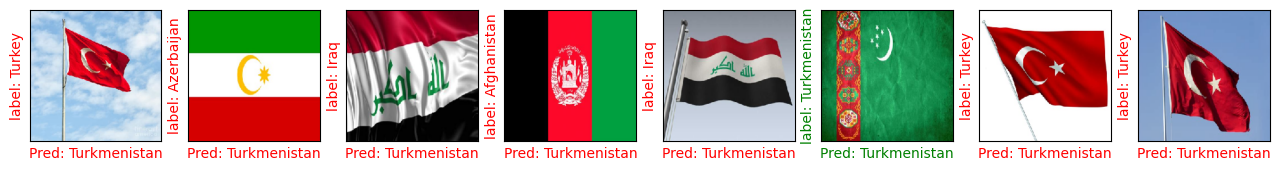

In [14]:
def test_model(model, test_datagen):
    """
    The test_model function plots some flags from the data generator so that the model's progress can be seen
    
    model: The model created fro classification
    test_datagen: The generator of the data that is defined
    
    return: 8 flag images with actual labels and predicted labels
    """
    examples, labels= next(test_datagen)
    pred_y = model.predict(examples, verbose = False)
    class_pred = np.argmax(pred_y[0])
    plt.figure(figsize=(16, 10))
    for i, image in enumerate(examples):
        gt = countries[np.argmax(labels[i])]
        predict_name = countries[np.argmax(pred_y[i])]

        color = 'green' if gt == predict_name else 'red'
        plt.subplot(1, 8, i+1)
        plt.imshow(image)
        plt.xlabel('Pred: {}'.format(predict_name), color=color)
        plt.ylabel('label: {}'.format(gt), color=color)
        plt.xticks([])
        plt.yticks([])
        if i == 7:
            break
    plt.show()

def test(model):
    test_datagen = test_generator
    
    test_model(model, test_datagen)
test(model)

# 6. Define Callback

In [15]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #Every five epochs run the test function
        if epoch % 5 == 0:
            test(self.model)

# 7. Training the classification model

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 2.1360 - accuracy: 0.2714

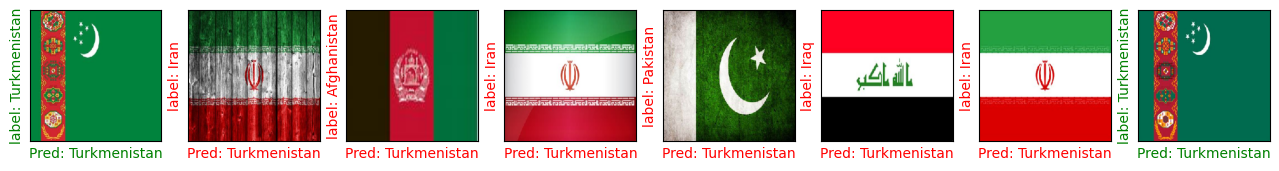

35/35 [==============================] - 26s 256ms/step - loss: 2.1360 - accuracy: 0.2714 - val_loss: 1.9432 - val_accuracy: 0.1562
Epoch 2/50
35/35 [==============================] - 8s 212ms/step - loss: 1.4847 - accuracy: 0.4411 - val_loss: 2.0313 - val_accuracy: 0.1562
Epoch 3/50
35/35 [==============================] - 8s 213ms/step - loss: 1.2340 - accuracy: 0.5982 - val_loss: 2.1934 - val_accuracy: 0.1562
Epoch 4/50
35/35 [==============================] - 8s 212ms/step - loss: 0.9686 - accuracy: 0.6661 - val_loss: 2.5532 - val_accuracy: 0.0938
Epoch 5/50
35/35 [==============================] - 8s 214ms/step - loss: 0.8088 - accuracy: 0.7464 - val_loss: 2.5381 - val_accuracy: 0.2500
Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.7786

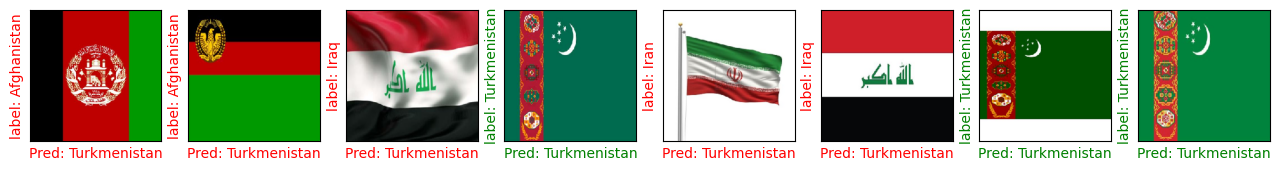

35/35 [==============================] - 8s 229ms/step - loss: 0.6504 - accuracy: 0.7786 - val_loss: 2.9368 - val_accuracy: 0.2188
Epoch 7/50
35/35 [==============================] - 8s 214ms/step - loss: 0.5707 - accuracy: 0.8107 - val_loss: 1.8602 - val_accuracy: 0.4219
Epoch 8/50
35/35 [==============================] - 8s 217ms/step - loss: 0.6199 - accuracy: 0.8018 - val_loss: 1.0676 - val_accuracy: 0.5781
Epoch 9/50
35/35 [==============================] - 8s 218ms/step - loss: 0.4569 - accuracy: 0.8643 - val_loss: 0.5737 - val_accuracy: 0.8125
Epoch 10/50
35/35 [==============================] - 8s 213ms/step - loss: 0.4369 - accuracy: 0.8625 - val_loss: 0.7269 - val_accuracy: 0.8125
Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8821

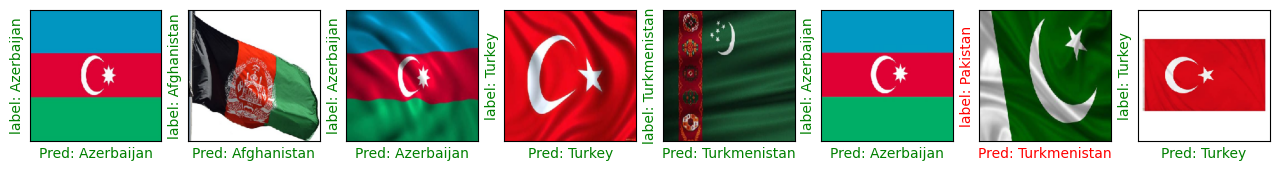

35/35 [==============================] - 8s 239ms/step - loss: 0.4050 - accuracy: 0.8821 - val_loss: 0.5242 - val_accuracy: 0.8125
Epoch 12/50
35/35 [==============================] - 7s 210ms/step - loss: 0.3975 - accuracy: 0.8625 - val_loss: 0.4010 - val_accuracy: 0.8750
Epoch 13/50
35/35 [==============================] - 8s 213ms/step - loss: 0.3381 - accuracy: 0.8946 - val_loss: 0.3924 - val_accuracy: 0.8750
Epoch 14/50
35/35 [==============================] - 8s 213ms/step - loss: 0.3058 - accuracy: 0.8893 - val_loss: 0.4250 - val_accuracy: 0.8594
Epoch 15/50
35/35 [==============================] - 7s 211ms/step - loss: 0.2967 - accuracy: 0.9107 - val_loss: 0.3977 - val_accuracy: 0.8594
Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8893

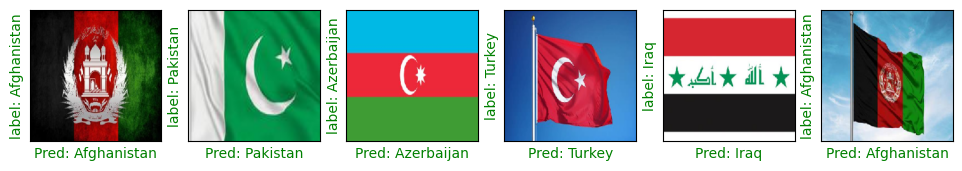

35/35 [==============================] - 8s 234ms/step - loss: 0.3043 - accuracy: 0.8893 - val_loss: 0.3312 - val_accuracy: 0.8906
Epoch 17/50
35/35 [==============================] - 7s 211ms/step - loss: 0.2180 - accuracy: 0.9286 - val_loss: 0.3089 - val_accuracy: 0.9062
Epoch 18/50
35/35 [==============================] - 7s 212ms/step - loss: 0.2943 - accuracy: 0.9054 - val_loss: 0.4299 - val_accuracy: 0.8438
Epoch 19/50
35/35 [==============================] - 8s 213ms/step - loss: 0.2333 - accuracy: 0.9125 - val_loss: 0.2160 - val_accuracy: 0.9375
Epoch 20/50
35/35 [==============================] - 8s 213ms/step - loss: 0.2918 - accuracy: 0.9071 - val_loss: 0.4574 - val_accuracy: 0.8750
Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9268

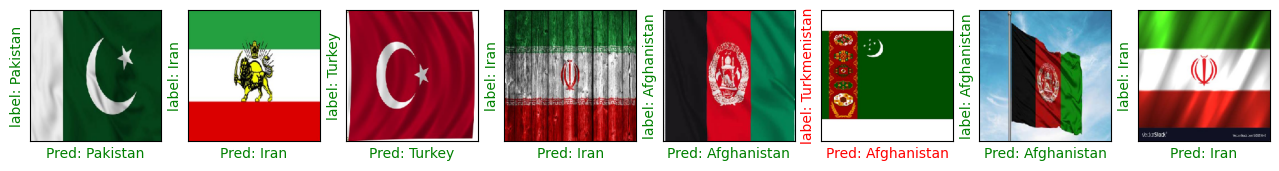

35/35 [==============================] - 9s 244ms/step - loss: 0.2281 - accuracy: 0.9268 - val_loss: 0.3183 - val_accuracy: 0.9219
Epoch 22/50
35/35 [==============================] - 8s 213ms/step - loss: 0.2506 - accuracy: 0.9196 - val_loss: 0.1663 - val_accuracy: 0.9375
Epoch 23/50
35/35 [==============================] - 7s 210ms/step - loss: 0.1801 - accuracy: 0.9518 - val_loss: 0.8415 - val_accuracy: 0.8125
Epoch 24/50
35/35 [==============================] - 7s 211ms/step - loss: 0.1768 - accuracy: 0.9446 - val_loss: 0.3446 - val_accuracy: 0.8906
Epoch 25/50
35/35 [==============================] - 8s 218ms/step - loss: 0.1935 - accuracy: 0.9250 - val_loss: 0.3915 - val_accuracy: 0.9219
Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9375

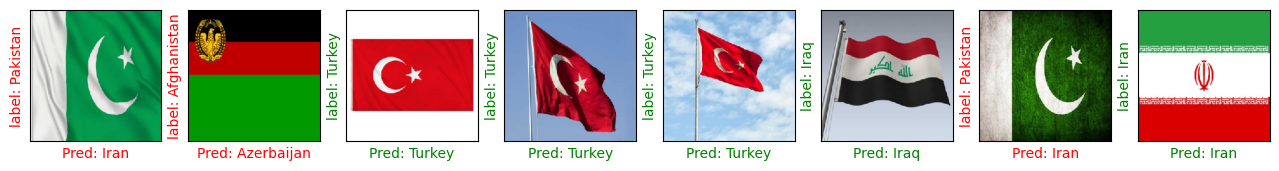

35/35 [==============================] - 8s 228ms/step - loss: 0.2035 - accuracy: 0.9375 - val_loss: 0.5867 - val_accuracy: 0.8594
Epoch 27/50
35/35 [==============================] - 7s 209ms/step - loss: 0.1938 - accuracy: 0.9321 - val_loss: 0.2428 - val_accuracy: 0.9062
Epoch 28/50
35/35 [==============================] - 8s 223ms/step - loss: 0.1810 - accuracy: 0.9357 - val_loss: 0.3046 - val_accuracy: 0.9375
Epoch 29/50
35/35 [==============================] - 7s 211ms/step - loss: 0.1836 - accuracy: 0.9446 - val_loss: 0.1624 - val_accuracy: 0.9688
Epoch 30/50
35/35 [==============================] - 7s 210ms/step - loss: 0.1562 - accuracy: 0.9446 - val_loss: 0.2674 - val_accuracy: 0.9375
Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9464

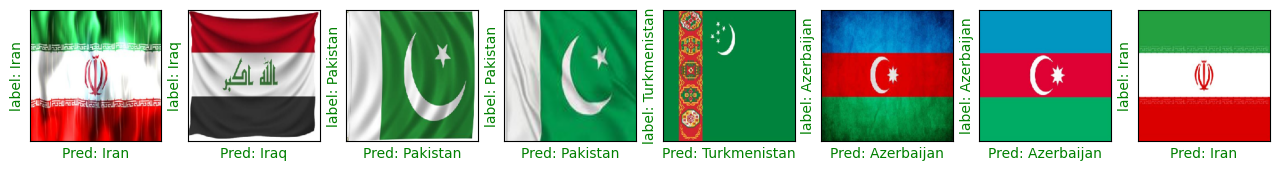

35/35 [==============================] - 8s 230ms/step - loss: 0.1619 - accuracy: 0.9464 - val_loss: 0.3692 - val_accuracy: 0.9688
Epoch 32/50
35/35 [==============================] - 8s 213ms/step - loss: 0.1563 - accuracy: 0.9429 - val_loss: 0.2223 - val_accuracy: 0.9531
Epoch 33/50
35/35 [==============================] - 8s 214ms/step - loss: 0.1626 - accuracy: 0.9464 - val_loss: 0.4486 - val_accuracy: 0.9219
Epoch 34/50
35/35 [==============================] - 8s 213ms/step - loss: 0.1710 - accuracy: 0.9375 - val_loss: 0.1800 - val_accuracy: 0.9531
Epoch 35/50
35/35 [==============================] - 7s 209ms/step - loss: 0.1131 - accuracy: 0.9625 - val_loss: 0.2097 - val_accuracy: 0.9375
Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9768

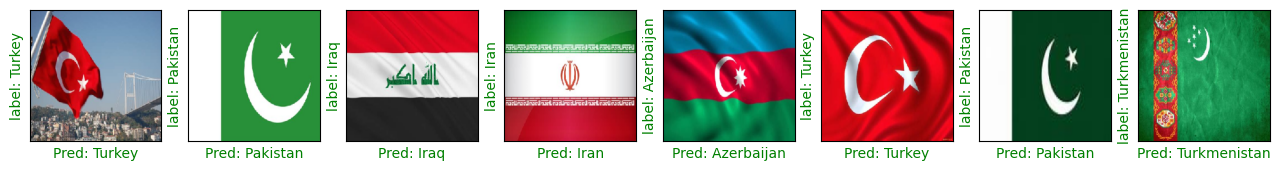

35/35 [==============================] - 8s 226ms/step - loss: 0.0713 - accuracy: 0.9768 - val_loss: 0.2269 - val_accuracy: 0.9062
Epoch 37/50
35/35 [==============================] - 7s 211ms/step - loss: 0.0777 - accuracy: 0.9786 - val_loss: 0.1208 - val_accuracy: 0.9531
Epoch 38/50
35/35 [==============================] - 8s 213ms/step - loss: 0.1292 - accuracy: 0.9554 - val_loss: 0.0884 - val_accuracy: 0.9844
Epoch 39/50
35/35 [==============================] - 8s 215ms/step - loss: 0.1351 - accuracy: 0.9500 - val_loss: 2.9308 - val_accuracy: 0.6094
Epoch 40/50
35/35 [==============================] - 7s 209ms/step - loss: 0.1459 - accuracy: 0.9571 - val_loss: 0.1940 - val_accuracy: 0.9531
Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9714

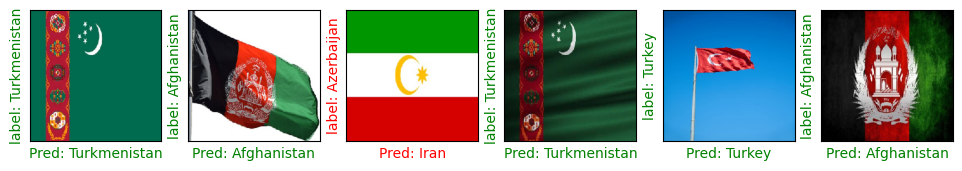

35/35 [==============================] - 8s 223ms/step - loss: 0.0904 - accuracy: 0.9714 - val_loss: 0.1684 - val_accuracy: 0.9844
Epoch 42/50
35/35 [==============================] - 8s 219ms/step - loss: 0.1074 - accuracy: 0.9643 - val_loss: 0.1637 - val_accuracy: 0.9375
Epoch 43/50
35/35 [==============================] - 8s 213ms/step - loss: 0.1379 - accuracy: 0.9536 - val_loss: 0.2585 - val_accuracy: 0.9531
Epoch 44/50
35/35 [==============================] - 7s 212ms/step - loss: 0.1280 - accuracy: 0.9554 - val_loss: 0.0467 - val_accuracy: 0.9844
Epoch 45/50
35/35 [==============================] - 8s 215ms/step - loss: 0.0867 - accuracy: 0.9750 - val_loss: 0.2151 - val_accuracy: 0.9531
Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9714

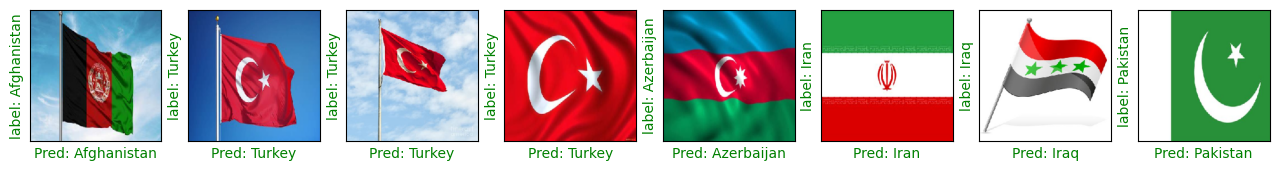

35/35 [==============================] - 8s 230ms/step - loss: 0.0831 - accuracy: 0.9714 - val_loss: 0.0839 - val_accuracy: 0.9688
Epoch 47/50
35/35 [==============================] - 8s 223ms/step - loss: 0.0706 - accuracy: 0.9732 - val_loss: 0.3635 - val_accuracy: 0.9375
Epoch 48/50
35/35 [==============================] - 7s 209ms/step - loss: 0.0810 - accuracy: 0.9750 - val_loss: 0.2924 - val_accuracy: 0.9531
Epoch 49/50
35/35 [==============================] - 7s 211ms/step - loss: 0.0771 - accuracy: 0.9786 - val_loss: 0.1108 - val_accuracy: 0.9844
Epoch 50/50
35/35 [==============================] - 8s 212ms/step - loss: 0.1232 - accuracy: 0.9679 - val_loss: 0.1836 - val_accuracy: 0.9531


In [16]:
"""
#We could use earlystopping to restore weights if validation loss doesn't get better in five epochs
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)
"""

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size,
                    epochs=50, 
                    batch_size=batch_size,
                    callbacks=[
              ShowTestImages()]
)

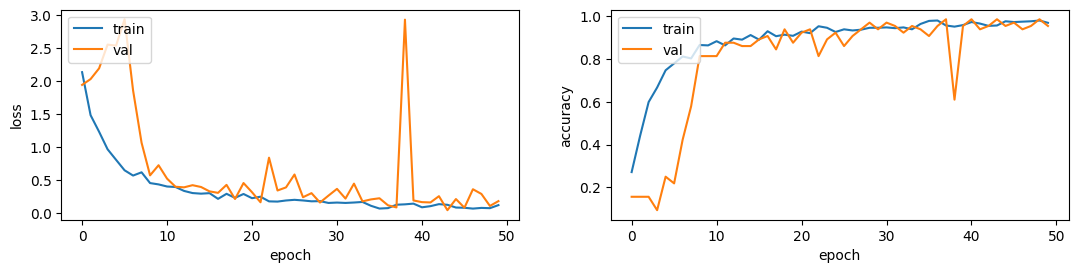

In [17]:
#plot the results of the training
plt.figure(figsize=(13,6))
for i, (name, value) in enumerate(history.history.items()):
    if re.search('loss', name):
        plt.subplot(2,2,1)
        plt.plot(history.history[name])
        plt.ylabel('loss')
    else:
        plt.subplot(2,2,2)
        plt.plot(history.history[name])
        plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 8. Evaluate the final model

In [18]:
loss, acc = model.evaluate(test_generator, verbose=True, batch_size=16)
print("Test accuracy: {:.2f}% \nTest loss: {:.4f}".format(acc*100, loss))


5/5 [==============================] - 0s 46ms/step - loss: 0.1690 - accuracy: 0.9714
Test accuracy: 97.14% 
Test loss: 0.1690


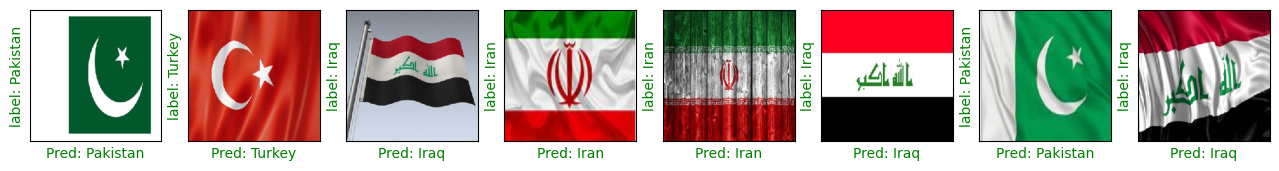

In [19]:
test(model)

# Confusion Matrix

In [ ]:
"""
import itertools
from sklearn.metrics import classification_report, confusion_matrix

true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
class_names = test_generator.class_indices.keys()

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()"""